In [18]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

In [19]:
def calcularHu(imaxe):
    contours=cv2.findContours(imaxe2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)

    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        roi = imaxe2[y:y + h, x:x + w]
        Hu = cv2.HuMoments(cv2.moments(roi)).flatten()
        
    return Hu

[ 1.44090556e-03  1.16764113e-06  1.47202321e-10  1.42990728e-10
  2.07028249e-20  1.54512126e-13 -1.32641411e-21]


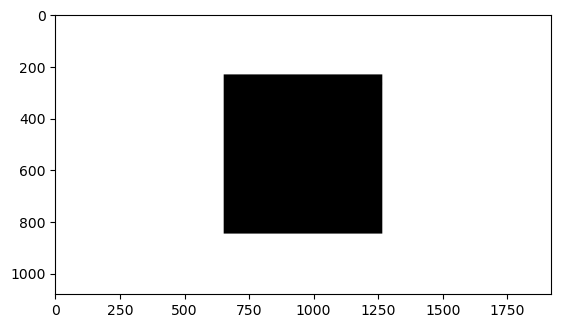

In [28]:
img1=cv2.imread('probasSimples/cadrado3.png',0)

Hu=calcularHu(img1)

print(Hu)

t=np.arange(0,len(Hu),1)
plt.imshow(img1,cmap="gray")
plt.show()

[ 1.44090556e-03  1.16764113e-06  1.47202321e-10  1.42990728e-10
  2.07028249e-20  1.54512126e-13 -1.32641411e-21]


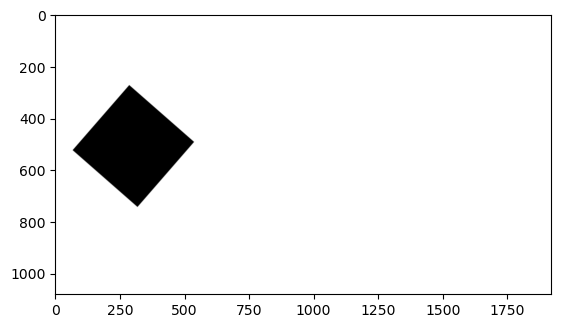

In [29]:
img2=cv2.imread('probasSimples/cadrado4.png',0)

Hu=calcularHu(img2)

print(Hu)

t=np.arange(0,len(Hu),1)
plt.imshow(img2,cmap="gray")
plt.show()

<h2>Extracción de contornos e construcion dos datos</h2>

Tomamos as imaxes de ambos paths, obtemos os contornos empregando a aproximación de Ten Chin, o cal aumenta a precisión e o rendemento do clasificador. Se a imaxe é unha botella, pertence a clase 1, senón, a clase 0.

In [30]:
imgPaths = ['botellas/', 'bolboretas/','cubertos/']
numImages = [65, 20,32]  # especificar o numero de imaxes en cada path
dataset = open('ClasificadoresBy/dataset6.csv', 'w')

for imgPath, imNum in zip(imgPaths, numImages):
    
    if 'botellas/' in imgPath:
        label=',1'
        
    elif 'bolboretas/' in imgPath:
        label=',0'
        
    elif 'cubertos/' in imgPath:
        label=',2'

    for index in range(imNum):
        img = cv2.imread(imgPath + str(index + 1) + '.jpg')

        if 'bolboretas/' in imgPath and index == 15:
            continue

        imaxe2 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        Hu=calcularHu(imaxe2)

        Hu_str = ",".join(map(str, Hu))

        dataset.write(Hu_str + label)
        dataset.write('\n')

dataset.close()

<h2>Clase encargada de manexar os datos e dividir o dataset en coxunto de adestramento e de test</h2>

In [4]:
class Data:
    trainData: np.array
    testData: np.array
    trainLabel: np.array
    testLabel: np.array

    def __init__(self, data, split_rate=0.2, bias=True, normal=False):
        self.trainData: np.array
        self.testData: np.array
        self.trainLabel: np.array
        self.testLabel: np.array
        self.split_rare = split_rate
        self.data = data
        self.bias = bias
        self.normal = normal
        self.prepare_data()

    def prepare_data(self):
        if self.normal:
            self.normalizer()

        if self.bias:
            self.data = np.insert(self.data, 0, 1, axis=1)

        self.trainData, self.testData, self.trainLabel, self.testLabel = train_test_split(self.data[:, :-1],
                                                                                          self.data[:, -1],
                                                                                          test_size=self.split_rare,
                                                                                          random_state=42)

    def normalizer(self):
        norm = np.linalg.norm(self.data[:, :-1])
        self.data[:, :-1] = self.data[:, :-1] / norm

<h3>Cálculo da accuracy e función para cargar os datos</h3>

In [5]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


def load_data(path, array=True):
    train = pd.read_csv(path)
    if array:
        train = train.to_numpy()
    return train

<h2>Clase que contén o clasificador bayesiano cadrático</h2>

In [14]:
class ByQuadratic:
    def __init__(self, data):
        self.data = data
        self.class_name_list = np.unique(data.trainLabel)
        self.class_name_list.sort()
        self.means = None
        self.priors = None
        self.covariance_matrix = None

    def calculate_prior(self):
        prior = np.zeros(self.class_name_list.size)
        for index, className in enumerate(self.class_name_list):
            prior[index] = self.data.trainLabel[self.data.trainLabel == className].size \
                           / self.data.trainLabel.size
        self.priors = prior

    def calculate_mean(self):
        means = np.zeros((self.class_name_list.size, self.data.trainData.shape[1]))
        covariance_matrix = []
        for index, className in enumerate(self.class_name_list):
            row_data = self.data.trainData[self.data.trainLabel == className]
            mean = np.asmatrix(np.mean(row_data, axis=0))
            means[index] = mean
            cov_matrix = (row_data - mean).T @ (row_data - mean) / self.data.trainData.shape[0]
            covariance_matrix.append(cov_matrix)

        self.means = means
        self.covariance_matrix = covariance_matrix

    def predict(self, data):
        probs = np.asmatrix(np.zeros((data.shape[0], self.priors.size)))
        for index, class_abel in enumerate(self.class_name_list):
            probs[:, index] = self.probability(data, index)
        return np.argmax(probs, axis=1)

    def probability(self, data, index):
        X = np.asmatrix(data)
        cov_matrix_det = np.linalg.det(self.covariance_matrix[index])
        cov_matrix_inv = np.linalg.pinv(self.covariance_matrix[index])
        Xm = X - self.means[index]
        Xm_covariance = (Xm @ cov_matrix_inv) @ Xm.T
        Xm_covariance_sum = Xm_covariance.sum(axis=1)
        return -0.5 * Xm_covariance_sum - 0.5 * np.log(cov_matrix_det) + np.log(self.priors[index])

    def fix(self):
        self.calculate_prior()
        self.calculate_mean()

def mostrarFallos(fallos,dataPath):
    dataset=open(dataPath,'r')
    lineas=dataset.readlines()

    imaxes=[]

    for indx in fallos:
        if indx<=65:
            imaxes.append('botellas/'+str(indx)+'.jpg')

        elif indx>65 and indx<=84:
            imaxes.append('bolboretas/'+str(indx-65)+'.jpg')

        elif indx>=85:
            imaxes.append('cubertos/'+str(indx-85)+'.jpg')

    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

    for i in range(len(imaxes)):
        img = cv2.imread(imaxes[i], 0)
        plt.subplot(1, len(imaxes), i+1, frame_on=False)

        plt.imshow(img, cmap="gray")

        plt.xticks([])
        plt.yticks([])

    dataset.close()

    plt.show()

<h2>Adestramento, test e avaliación</h2>

Cargamos os tres datasets, adestramos o clasificador con cada un e avaliamos. Cárganse tamén os dataset que correspoden aos métodos baseados en contorno para facilitar a comparación.

O dataset 1 corresponde coa función radial, o 2 cos descritores de Fourier e o 3 cos descritores dos momentos invariantes de Hu.



------Entrenamiento Dataset 6------
Train ACC = 80.43478260869566
Train confusion matrix = 
[[10  3  1]
 [ 8 41  3]
 [ 0  3 23]]
Train precission = [0.55555556 0.87234043 0.85185185]
Train recall = [0.71428571 0.78846154 0.88461538]
Train F1_score = [0.625      0.82828283 0.86792453]

------Test Dataset 6------
test ACC = 86.95652173913044 

Test     confusion matrix = 
[[ 4  0  1]
 [ 0 11  1]
 [ 0  1  5]]
Test precission = [1.         0.91666667 0.71428571]
Test recall = [0.8        0.91666667 0.83333333]
Test F1_score = [0.88888889 0.91666667 0.76923077]


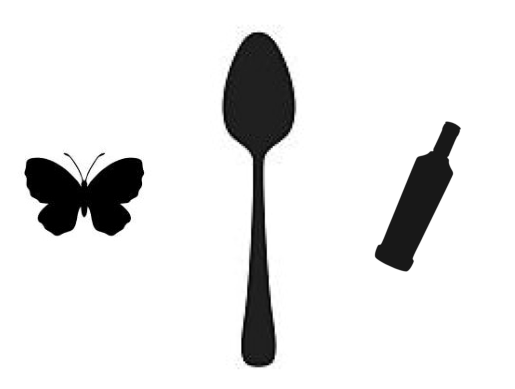

In [15]:
listdata = ['ClasificadoresBy/dataset6.csv']

resultados=[]
with open(listdata[0], 'r') as dataset:
    for linea in dataset:
        # Dividir la línea por comas y convertir cada elemento a un número flotante
        elementos = [float(e) for e in linea.strip().split(',')[:-1]]
        elementos_redondeados = [round(e, 8) for e in elementos]
        resultados.append(elementos_redondeados)

rawData = load_data(listdata[0])
data = Data(rawData, bias=False)
#Instantacionamos e adestramos
model_q = ByQuadratic(data)
model_q.fix()

#Predecimos co modelos adestrado os datos de adestramento
# e test. Ollo: non se gardan os datos derivados do adestramento
#Ti debes gardalos en disco e lelos cando os precises.
predicted_train = model_q.predict(data.trainData)
predicted_test = model_q.predict(data.testData)

print(f"\n\n------Entrenamiento Dataset {listdata[0][-5]}------")

print(f"Train ACC = {accuracy_metric(data.trainLabel, predicted_train)}")
print(f"Train confusion matrix = \n{confusion_matrix(data.trainLabel,np.asarray(predicted_train))}")
print(f"Train precission = {precision_score(data.trainLabel,np.asarray(predicted_train),average=None)}")
print(f"Train recall = {recall_score(data.trainLabel,np.asarray(predicted_train),average=None)}")
print(f"Train F1_score = {f1_score(data.trainLabel,np.asarray(predicted_train),average=None)}")

print(f"\n------Test Dataset {listdata[0][-5]}------")

print(f"test ACC = {accuracy_metric(data.testLabel, np.asarray(predicted_test))} \n")
print(f"Test     confusion matrix = \n{confusion_matrix(data.testLabel,np.asarray(predicted_test))}")
print(f"Test precission = {precision_score(data.testLabel,np.asarray(predicted_test),average=None)}")
print(f"Test recall = {recall_score(data.testLabel,np.asarray(predicted_test),average=None)}")
print(f"Test F1_score = {f1_score(data.testLabel,np.asarray(predicted_test),average=None)}")

fallos=[]
misclassified_indices = np.where(data.testLabel != np.asarray(predicted_test).T[0])

for misclassified_index in misclassified_indices[0]:
    for idx, vector in enumerate(resultados):
        if np.linalg.norm(data.testData[misclassified_index] - np.array(vector))<0.000001:
            fallos.append(idx)
            
mostrarFallos(fallos,listdata[0])

<h2>Análise de resultados</h2>

A matriz de confusión mostra que hai un total de 8 verdadeiros negativos e 4 verdadeiros positivos, con 1 falso positivo e 5 falsos negativos. Clasificanse moi ben as instancias da clase 1 (80% de precisión), en cambio, as imaxes de clase 0, só se clasificaron correctamente no 61.5%. O recall mostra que se identificaron de maneira correcta máis imaxes da clase 0 que da clase 1, unha posible causa sería unha maior diversidade nas formas dos cotornos, que permite xeralizar mellor, os contornos da clase 1 son moi similares en área.

En comparación aos clasificadores de contorno, funciona peor que os dous clasificadores. Isto débese a que os contornos das botellas son moi similares en área, e diferencianse en detalles finos, é dicir, varias imaxes de distintas botellas que se diferencian só no pescozo ou na base darán o mesmo resultado que pasarlle a mesma imaxe varias veces porque os detalles describense mellor cos puntos do contorno externo. Este tamén é o motivo polo que se distinguen mellor as imaxes da clase cero que as da clase 1, hai unha gran diversidade na área das bolboretas.